**Goal**: Fit contrasts and generate differential gene lists for comparison to tables S1 and S2 of Sci. Rep. 7:42225.

## Load data

In [1]:
%cd ../data

/home/explorer/BMS270/data


In [2]:
import numpy as np

In [3]:
def clip(s):
    """Coerce kallisto est_count floating point value to nearest integer."""
    # Note that the max function shouldn't be necessary, as all est_counts should be positive
    return max(0,int(float(s)+.5))

Parse table of per-sample estimated counts from kallisto.  The table is in CDT format and has been filtered for genes with $TPM \geq 10$ in at least one sample, exactly as in the TPM file that we were previously working with.

In [4]:
from csv import reader, excel_tab
orfs = []
names = []
data = []
fin = reader(open("GSE88801_kallisto_est_counts_thresh10.cdt"),dialect=excel_tab)
header = next(fin)[4:]
eweights = next(fin)[4:]
for row in fin:
    orfs.append(row[1])
    names.append(row[2])
    data.append([clip(i) for i in row[4:]])

Here, I convert the count matrix to a numpy array.  This is mainly to allow passing the matrix directly to R via ryp2.  Since we will be passing data to R via flat files, we could have skipped this step and worked with the **data** list of lists instead.

In [5]:
C = np.array(data)
C.shape

(9939, 36)

Load the table of sample descriptions and generate an easy to parse "state" column for R.  In order to keep our R code simple, we will make the row order of the sample table match the column order of the count matrix.  Therefore, we use a dictionary, **name2sample**, to index the original sample table by sample name.

In [6]:
from csv import reader

In [7]:
fp = reader(open("sample_table_v2.csv"))
sample_header = next(fp)
samples = []
name2sample = {}
for i in fp:
    samples.append(i)
    name2sample[i[0]] = i

In [8]:
sample_header

['name', 'infection', 'strain', 'time', 'replicate']

In [9]:
out = open("sample_table_v2.tdt","w")
out.write("\t".join(sample_header+["state"])+"\n")
# Loop over the count matrix header to match its ordering of the samples
for i in header:
    # Use our dictionary to look up the corresponding row of the sample table
    s = name2sample[i]
    # Generate unique state names by concatenating the three parameters that distinguish the states
    # (strain, infection, and time)
    out.write("\t".join(s + ["%s.%s.%s" % (s[2],s[1],s[3])])+"\n")
out.close()

Write the count matrix in an easily parsed tab delimited format (relative to the original CDT file, we drop the eweight row and all of the extra annotation columns)

In [10]:
out = open("GSE88801_kallisto_est_counts_thresh10.txt","w")
out.write("\t".join(["gene"]+header)+"\n")
for (name,row) in zip(names,C):
    out.write("\t".join([name]+[str(i) for i in row])+"\n")
out.close()

Use rpy2 to connect our Jupyter notebook to an R interpreter (in addition to the python3 interpreter that we're already connected to).  Subsequent cells that start with **%%R** will be executed by the R interpreter.  In this case, we are using ryp2 so that we can document our R and Python steps in one place.  We could just as well use separate Jupyter and RStudio notebooks, as long as we were careful to execute the commands in the right order.  In other contexts, we might choose to use rpy2 pass data back and forth between R and Python -- this is very convenient, but we need to be careful that nothing falls through the cracks during the between-language data conversions.

In [11]:
%load_ext rpy2.ipython

Load the R modules necessary for limma analysis (analogous to **import** in Python)

In [12]:
%%R
library(limma)
library(edgeR)

Read the sample table into R.  Note that R automatically converts the text columns into *factors* (essentially, qualitative labels) and the integer columns into integers.

In [13]:
%%R
samples <- read.delim("sample_table_v2.tdt")
print(summary(samples))

         name         infection   strain        time      replicate
 GSM2348248: 1   Dead      :12   BMDM:18   Min.   : 4   Min.   :1  
 GSM2348249: 1   Live      :12   J774:18   1st Qu.: 4   1st Qu.:1  
 GSM2348250: 1   uninfected:12             Median :14   Median :2  
 GSM2348251: 1                             Mean   :14   Mean   :2  
 GSM2348252: 1                             3rd Qu.:24   3rd Qu.:3  
 GSM2348253: 1                             Max.   :24   Max.   :3  
 (Other)   :30                                                     
                state   
 BMDM.Dead.24      : 3  
 BMDM.Dead.4       : 3  
 BMDM.Live.24      : 3  
 BMDM.Live.4       : 3  
 BMDM.uninfected.24: 3  
 BMDM.uninfected.4 : 3  
 (Other)           :18  


Specify the model to be fit.  Here, we just want to fit the means over the three replicates for each distinct state (equivalent to assuming that there are enough context-dependent effects that none of the parameters are additive).

In [14]:
%%R
state <- samples$state
# Specify the model: the 0 removes the default intercept parameter, so we just fit a separate mean for each state
#  (If you'd like to try an alternative model, bind the appropriate columns of the samples data.frame above
#   and try: d <- model.matrix(~infection+strain+time) for an independently additive model)
d <- model.matrix(~0+state)
# This step just cleans up R's default parameter names
colnames(d) <- gsub("state","",colnames(d))
print(colnames(d))

 [1] "BMDM.Dead.24"       "BMDM.Dead.4"        "BMDM.Live.24"      
 [4] "BMDM.Live.4"        "BMDM.uninfected.24" "BMDM.uninfected.4" 
 [7] "J774.Dead.24"       "J774.Dead.4"        "J774.Live.24"      
[10] "J774.Live.4"        "J774.uninfected.24" "J774.uninfected.4" 


Read and normalize the count matrix

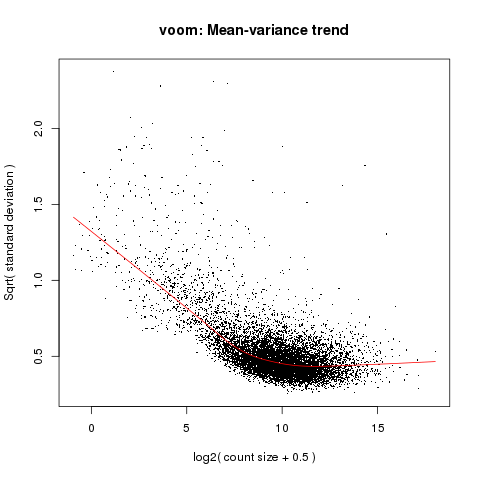

In [15]:
%%R
# Read the count matrix, using the gene column as row names
C <- read.delim("GSE88801_kallisto_est_counts_thresh10.txt",row.names=1)
# Covert the matrix to limma's preferred format, implicitly log2 transforming and depth normalizing to CPM values
dge <- DGEList(counts=C)
# Apply between-sample TMM normalization
dge <- calcNormFactors(dge)
# Estimate the mean-variance trend via locally-linear regression and use this trend
# to assign weights to the observations (counts)
v <- voom(dge, d, plot = TRUE)

Fit the model (*i.e.*, calculate the state means for each gene), convert to contrasts of interest, and re-estimate the variances based on the global variance distribution.

In [16]:
%%R
# Fit the model (classic linear regression)
fit <- lmFit(v, d)
# Generate the contrast matrix
contrast.matrix <- makeContrasts(# S1 contrast
                                 BMDM.uninfected.24-BMDM.uninfected.4,
                                 # S2 contrasts
                                 BMDM.Live.4-BMDM.uninfected.4,BMDM.Dead.4-BMDM.uninfected.4,
                                 BMDM.Live.24-BMDM.uninfected.24,BMDM.Dead.24-BMDM.uninfected.24,
                                 J774.Live.4-J774.uninfected.4,J774.Dead.4-J774.uninfected.4,
                                 J774.Live.24-J774.uninfected.24,J774.Dead.24-J774.uninfected.24,
                                 levels=d)
# Apply the contrast matrix
fit2 <- contrasts.fit(fit, contrast.matrix)
# Apply Empirical Bayes "shrinkage"
fit2 <- eBayes(fit2)
# Simple summary of significantly differential genes with no fold change filter
print(summary(decideTests(fit2)))

   BMDM.uninfected.24 - BMDM.uninfected.4 BMDM.Live.4 - BMDM.uninfected.4
-1                                   2069                            2288
0                                    5706                            5895
1                                    2164                            1756
   BMDM.Dead.4 - BMDM.uninfected.4 BMDM.Live.24 - BMDM.uninfected.24
-1                            1798                              2050
0                             6672                              5845
1                             1469                              2044
   BMDM.Dead.24 - BMDM.uninfected.24 J774.Live.4 - J774.uninfected.4
-1                              1267                             232
0                               7377                            9293
1                               1295                             414
   J774.Dead.4 - J774.uninfected.4 J774.Live.24 - J774.uninfected.24
-1                             162                              2059
0             

Same summary as above, but with a 2x fold-change filter (1 after $\log_2$ transform)

In [17]:
%%R
print(summary(decideTests(fit2,lfc=1)))

   BMDM.uninfected.24 - BMDM.uninfected.4 BMDM.Live.4 - BMDM.uninfected.4
-1                                    680                             673
0                                    8581                            8478
1                                     678                             788
   BMDM.Dead.4 - BMDM.uninfected.4 BMDM.Live.24 - BMDM.uninfected.24
-1                             478                               725
0                             8794                              8512
1                              667                               702
   BMDM.Dead.24 - BMDM.uninfected.24 J774.Live.4 - J774.uninfected.4
-1                               383                              37
0                               9119                            9755
1                                437                             147
   J774.Dead.4 - J774.uninfected.4 J774.Live.24 - J774.uninfected.24
-1                              21                               560
0             

To see the details of the differential genes (rather than just summary counts) we'll use **topTable**.  By default, it reports the 10 most significant genes based on F-test across all parameters.

In [18]:
%%R
print(topTable(fit2))

                   BMDM.uninfected.24...BMDM.uninfected.4
ENSMUSG00000000957                              0.6866017
ENSMUSG00000023341                              0.9722481
ENSMUSG00000050370                             -4.7094262
ENSMUSG00000030142                             -0.4031129
ENSMUSG00000031613                              2.7702055
ENSMUSG00000082292                              1.3588915
ENSMUSG00000074896                              1.7229340
ENSMUSG00000028270                              2.3299295
ENSMUSG00000037405                              0.6149907
ENSMUSG00000029561                              0.7866550
                   BMDM.Live.4...BMDM.uninfected.4
ENSMUSG00000000957                        4.750471
ENSMUSG00000023341                        6.196596
ENSMUSG00000050370                        2.536793
ENSMUSG00000030142                        5.067034
ENSMUSG00000031613                       -1.115454
ENSMUSG00000082292                        5.663051
ENSMU

In [19]:
%%R
print(colnames(fit2$coefficients))

[1] "BMDM.uninfected.24 - BMDM.uninfected.4"
[2] "BMDM.Live.4 - BMDM.uninfected.4"       
[3] "BMDM.Dead.4 - BMDM.uninfected.4"       
[4] "BMDM.Live.24 - BMDM.uninfected.24"     
[5] "BMDM.Dead.24 - BMDM.uninfected.24"     
[6] "J774.Live.4 - J774.uninfected.4"       
[7] "J774.Dead.4 - J774.uninfected.4"       
[8] "J774.Live.24 - J774.uninfected.24"     
[9] "J774.Dead.24 - J774.uninfected.24"     


Same thing, but considering only a single contrast and filtering for at least a 2x fold change

In [20]:
%%R
print(topTable(fit2, coef="BMDM.uninfected.24 - BMDM.uninfected.4", lfc=1, p.value = .05))

                       logFC     AveExpr         t      P.Value    adj.P.Val
ENSMUSG00000031613  2.770205  0.01606512  25.32290 3.756218e-21 3.733305e-17
ENSMUSG00000022351 -2.698628  6.47320365 -20.97155 6.354449e-19 3.157843e-15
ENSMUSG00000070348 -4.363873  8.41934975 -20.14689 1.868026e-18 6.188771e-15
ENSMUSG00000024030  2.740424  6.82440038  19.27584 6.089099e-18 1.354941e-14
ENSMUSG00000053040  2.759973  3.40438541  19.19441 6.816285e-18 1.354941e-14
ENSMUSG00000036833  1.691108  5.42121904  18.69190 1.380075e-17 1.959509e-14
ENSMUSG00000013089 -4.054002  5.10816666 -18.81725 1.155646e-17 1.914328e-14
ENSMUSG00000034926 -2.653638 -0.35467127 -18.51025 1.788036e-17 1.974587e-14
ENSMUSG00000029650  2.840585  2.30118767  18.35677 2.229184e-17 2.215586e-14
ENSMUSG00000032915  3.768694 -0.63361827  18.55579 1.675283e-17 1.974587e-14
                          B
ENSMUSG00000031613 38.20381
ENSMUSG00000022351 33.11143
ENSMUSG00000070348 32.13549
ENSMUSG00000024030 30.99876
ENSMUSG000000

Extract the topTable results from R by writing them to CSV formatted text files (we choose comma, rather than tab, delimiters because write.csv has slightly better documentation).  We set **n=40000** to make sure we get all genes passing the filter (for **t0**) or *all* genes (for **t1**).

In [21]:
%%R
for(tc in colnames(fit2$coefficients)){
  print(tc)
  # Extract all genes significantly differential on this contrast for a 2x fold change cutoff and 5% FDR
  # Use write.csv rather than write.table for clean compatibility with python's csv.reader
  write.csv(topTable(fit2, coef=tc, n = 40000, lfc=1, p.value = .05),
            paste("limma1.",gsub(" ","",tc),".t0.csv",sep=""))
  # Extract the adjusted p-values for this contrast for all genes, independent of significance
  write.csv(topTable(fit2, coef=tc, n = 40000),
            paste("limma1.",gsub(" ","",tc),".t1.csv",sep=""))
}

[1] "BMDM.uninfected.24 - BMDM.uninfected.4"
[1] "BMDM.Live.4 - BMDM.uninfected.4"
[1] "BMDM.Dead.4 - BMDM.uninfected.4"
[1] "BMDM.Live.24 - BMDM.uninfected.24"
[1] "BMDM.Dead.24 - BMDM.uninfected.24"
[1] "J774.Live.4 - J774.uninfected.4"
[1] "J774.Dead.4 - J774.uninfected.4"
[1] "J774.Live.24 - J774.uninfected.24"
[1] "J774.Dead.24 - J774.uninfected.24"


In [23]:
!ls limma1*.csv

limma1.BMDM.Dead.24-BMDM.uninfected.24.t0.csv
limma1.BMDM.Dead.24-BMDM.uninfected.24.t1.csv
limma1.BMDM.Dead.4-BMDM.uninfected.4.t0.csv
limma1.BMDM.Dead.4-BMDM.uninfected.4.t1.csv
limma1.BMDM.Live.24-BMDM.uninfected.24.t0.csv
limma1.BMDM.Live.24-BMDM.uninfected.24.t1.csv
limma1.BMDM.Live.4-BMDM.uninfected.4.t0.csv
limma1.BMDM.Live.4-BMDM.uninfected.4.t1.csv
limma1.BMDM.uninfected.24-BMDM.uninfected.4.t0.csv
limma1.BMDM.uninfected.24-BMDM.uninfected.4.t1.csv
limma1.J774.Dead.24-J774.uninfected.24.t0.csv
limma1.J774.Dead.24-J774.uninfected.24.t1.csv
limma1.J774.Dead.4-J774.uninfected.4.t0.csv
limma1.J774.Dead.4-J774.uninfected.4.t1.csv
limma1.J774.Live.24-J774.uninfected.24.t0.csv
limma1.J774.Live.24-J774.uninfected.24.t1.csv
limma1.J774.Live.4-J774.uninfected.4.t0.csv
limma1.J774.Live.4-J774.uninfected.4.t1.csv


## Explore R results in python

In [24]:
from csv import reader

Take a look at one of the differential gene sets

In [32]:
diff = []
fp = reader(open("limma1.J774.Live.24-J774.uninfected.24.t0.csv"))
header = next(fp)
header

['', 'logFC', 'AveExpr', 't', 'P.Value', 'adj.P.Val', 'B']

In [33]:
for row in fp:
    diff.append(row)

In [34]:
len(diff)

1324

In [35]:
diff[0]

['ENSMUSG00000029561',
 '4.14790799482096',
 '5.92808030053084',
 '27.6865251739655',
 '3.21404938959857e-22',
 '3.19444368832202e-18',
 '40.5937474409646']

In [36]:
diff[-1]

['ENSMUSG00000040010',
 '1.05493380595636',
 '3.90462262924173',
 '2.59115457599472',
 '0.0148911892378231',
 '0.0394592611105835',
 '-4.44078456948442']

In [37]:
list(zip(header,diff[-1]))

[('', 'ENSMUSG00000040010'),
 ('logFC', '1.05493380595636'),
 ('AveExpr', '3.90462262924173'),
 ('t', '2.59115457599472'),
 ('P.Value', '0.0148911892378231'),
 ('adj.P.Val', '0.0394592611105835'),
 ('B', '-4.44078456948442')]

In [39]:
for (i,j) in zip(header,diff[-1]):
    print("%10s: %20s" % (i,j))

          :   ENSMUSG00000040010
     logFC:     1.05493380595636
   AveExpr:     3.90462262924173
         t:     2.59115457599472
   P.Value:   0.0148911892378231
 adj.P.Val:   0.0394592611105835
         B:    -4.44078456948442


Parse the gene names from this list into a python **set**

In [40]:
s = set()
fp = reader(open("limma1.J774.Live.24-J774.uninfected.24.t0.csv"))
next(fp)
for row in fp:
    s.add(row[0])
len(s)

1324

Let's do the same parse for all of the differential gene lists.  We'll use **glob** to get a list of the appropriate file names and use a python **dict** to map list names to sets of gene names.

In [41]:
from glob import glob
glob("limma1*.csv")

['limma1.J774.Dead.4-J774.uninfected.4.t0.csv',
 'limma1.J774.Dead.24-J774.uninfected.24.t1.csv',
 'limma1.BMDM.Dead.24-BMDM.uninfected.24.t0.csv',
 'limma1.BMDM.Live.24-BMDM.uninfected.24.t1.csv',
 'limma1.J774.Dead.24-J774.uninfected.24.t0.csv',
 'limma1.BMDM.Dead.24-BMDM.uninfected.24.t1.csv',
 'limma1.BMDM.Dead.4-BMDM.uninfected.4.t0.csv',
 'limma1.BMDM.Dead.4-BMDM.uninfected.4.t1.csv',
 'limma1.BMDM.Live.24-BMDM.uninfected.24.t0.csv',
 'limma1.J774.Dead.4-J774.uninfected.4.t1.csv',
 'limma1.J774.Live.4-J774.uninfected.4.t0.csv',
 'limma1.BMDM.Live.4-BMDM.uninfected.4.t0.csv',
 'limma1.J774.Live.24-J774.uninfected.24.t1.csv',
 'limma1.BMDM.uninfected.24-BMDM.uninfected.4.t0.csv',
 'limma1.BMDM.uninfected.24-BMDM.uninfected.4.t1.csv',
 'limma1.BMDM.Live.4-BMDM.uninfected.4.t1.csv',
 'limma1.J774.Live.24-J774.uninfected.24.t0.csv',
 'limma1.J774.Live.4-J774.uninfected.4.t1.csv']

In [42]:
diff_genes = {}
for i in glob("limma1*.t0.csv"):
    s = set()
    fp = reader(open(i))
    next(fp)
    for row in fp:
        s.add(row[0])
    diff_genes[i.replace(".t0.csv","")] = s
    print(i,len(s))

limma1.J774.Dead.4-J774.uninfected.4.t0.csv 159
limma1.BMDM.Dead.24-BMDM.uninfected.24.t0.csv 820
limma1.J774.Dead.24-J774.uninfected.24.t0.csv 262
limma1.BMDM.Dead.4-BMDM.uninfected.4.t0.csv 1145
limma1.BMDM.Live.24-BMDM.uninfected.24.t0.csv 1427
limma1.J774.Live.4-J774.uninfected.4.t0.csv 184
limma1.BMDM.Live.4-BMDM.uninfected.4.t0.csv 1461
limma1.BMDM.uninfected.24-BMDM.uninfected.4.t0.csv 1358
limma1.J774.Live.24-J774.uninfected.24.t0.csv 1324


In [43]:
diff_genes.keys()

dict_keys(['limma1.J774.Live.4-J774.uninfected.4', 'limma1.BMDM.Live.4-BMDM.uninfected.4', 'limma1.J774.Dead.4-J774.uninfected.4', 'limma1.J774.Live.24-J774.uninfected.24', 'limma1.BMDM.Dead.4-BMDM.uninfected.4', 'limma1.BMDM.Dead.24-BMDM.uninfected.24', 'limma1.J774.Dead.24-J774.uninfected.24', 'limma1.BMDM.uninfected.24-BMDM.uninfected.4', 'limma1.BMDM.Live.24-BMDM.uninfected.24'])

Use **set.intersection** to find the common genes between two sets.

In [45]:
len(diff_genes["limma1.J774.Dead.4-J774.uninfected.4"].intersection(
diff_genes["limma1.BMDM.Dead.24-BMDM.uninfected.24"]))

64

In [49]:
s = diff_genes["limma1.J774.Dead.4-J774.uninfected.4"].intersection(
diff_genes["limma1.BMDM.Dead.24-BMDM.uninfected.24"])
len(s), sorted(s)[:10]

(64,
 ['ENSMUSG00000000686',
  'ENSMUSG00000002983',
  'ENSMUSG00000003541',
  'ENSMUSG00000003617',
  'ENSMUSG00000004105',
  'ENSMUSG00000006818',
  'ENSMUSG00000011008',
  'ENSMUSG00000015396',
  'ENSMUSG00000016283',
  'ENSMUSG00000017737'])

Same parse as before, but cutting for just the genes that are **up** in each contrast *(exercise for the reader -- try cutting for down regulated genes instead)*

In [48]:
up_genes = {}
for i in glob("limma1*.t0.csv"):
    s = set()
    fp = reader(open(i))
    next(fp)
    for row in fp:
        if(float(row[1]) > 0):
            s.add(row[0])
    up_genes[i.replace(".t0.csv","")] = s
    print(i,len(s))

limma1.J774.Dead.4-J774.uninfected.4.t0.csv 138
limma1.BMDM.Dead.24-BMDM.uninfected.24.t0.csv 437
limma1.J774.Dead.24-J774.uninfected.24.t0.csv 151
limma1.BMDM.Dead.4-BMDM.uninfected.4.t0.csv 667
limma1.BMDM.Live.24-BMDM.uninfected.24.t0.csv 702
limma1.J774.Live.4-J774.uninfected.4.t0.csv 147
limma1.BMDM.Live.4-BMDM.uninfected.4.t0.csv 788
limma1.BMDM.uninfected.24-BMDM.uninfected.4.t0.csv 678
limma1.J774.Live.24-J774.uninfected.24.t0.csv 764


Filtering example -- filter the CDT file from our PCA analysis for rows matching one of the differential gene sets

In [50]:
!ls -lrth *.cdt

-rw-r--r-- 1 explorer explorer 6.5M May 15 10:30 GSE88801_kallisto_TPMs_thresh10.cdt
-rw-r--r-- 1 explorer explorer 5.8M May 20 14:58 GSE88801_kallisto_TPMs_thresh10.centered.um.cdt
-rw-r--r-- 1 explorer explorer 4.3M May 22 00:10 GSE88801_kallisto_est_counts_thresh10.cdt
-rw-r--r-- 1 explorer explorer 9.1M May 22 00:10 GSE88801_kallisto_est_counts_thresh1.cdt
-rw-r--r-- 1 explorer explorer 5.4M May 23 13:52 PCA_clustering_example1.um.cdt
-rw-r--r-- 1 explorer explorer 5.4M May 23 13:52 PCA_clustering_example1.um.annotated.cdt
-rw-r--r-- 1 explorer explorer 726K May 27 22:28 PCA_clustering_example1.filter1.cdt
-rw-r--r-- 1 explorer explorer 722K May 27 22:28 PCA_clustering_example1.filter1.um.cdt
-rw-r--r-- 1 explorer explorer 725K May 27 22:28 PCA_clustering_example1.filter1.um.annotated.cdt


This first cell is a scouting run to check which column to filter on

In [51]:
fp = open("PCA_clustering_example1.um.annotated.cdt")
out = open("filter1.cdt","w")

out.write(fp.readline())
out.write(fp.readline())
for line in fp:
    fields = line.split("\t")
    print(fields)
    break

['GENE473X', 'ENSMUSG00000033904', 'Ccp110', '0', '1.000000', '-0.632738002193', '-0.754022498214', '-0.469551333638', '-0.541836751456', '1.11648773526', '-0.707358853449', '-0.701982749788', '1.1759442052', '-0.569361010398', '1.30968427371', '0.198331250618', '-0.635357761137', '-0.422493229659', '-0.834037913153', '0.780487473591', '-0.774961320781', '-0.838655432244', '-0.683922520138', '-0.682782350842', '-0.641666383429', '1.77210371565', '3.37771466302', '-0.572869134053', '0.322009926255', '1.88518665662', '-0.708819836217', '-0.301653684308', '-0.49044095138', '-0.796063706077', '-0.717580840027', '-0.662965792401', '-0.717393983679', '0.304952856829', '0.28015443204', '-0.767718033977', '3.10317688385', '1.27480702961', '0.774126940489', '-1.08062248822', '2.25930208426', '0.696956604001', '-1.20592972043', '-0.793343765305', '-0.798239623137', '0.0149461451361', '-0.873576808718', '0.0975038909272', '-0.424666599667', '0.684242271958', '-0.0915049984637', '2.25525185003', '

Here's the actual filtering cell

In [52]:
filter_set = diff_genes["limma1.J774.Dead.4-J774.uninfected.4"]

fp = open("PCA_clustering_example1.um.annotated.cdt")
out = open("filter1.cdt","w")
# Note that we want the two header lines no matter what
out.write(fp.readline())
out.write(fp.readline())
for line in fp:
    fields = line.split("\t")
    # Here's where we write only rows matching our gene list
    if(fields[1] in filter_set):
        out.write(line)
out.close()